In [9]:
import numpy as np
import pandas as pd
import IPython
import os
import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm, tqdm_notebook

from pyAudioAnalysis import audioSegmentation as aS
from pydub import AudioSegment
import pydub

import torchaudio
import torchaudio.transforms as transforms
import librosa
import librosa.display

In [23]:
import torch
from vocoder.denoiser import Denoiser
from vocoder.tacotron2.layers import TacotronSTFT, STFT
from vocoder.tacotron2.hparams import create_hparams
from vocoder.vocoder import load_mel, mel_to_wav

hparams = create_hparams()

stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()

denoiser = Denoiser(waveglow)

mel = load_mel('vocoder/arctic_a0008.wav', hparams, stft)

for sigma in [0.5, 0.7, 0.8, 0.9, 1.0]:
    mel_to_wav(mel, sigma, waveglow, denoiser, hparams, save=True, path='vocoder/audio_sigma{}.wav'.format(str(sigma)))

Using cache found in /home/shubhand/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


In [16]:
audio, rate = torchaudio.load("data/uk/treaty_uk.mp3")
print(rate)
IPython.display.Audio(audio.numpy(), rate=rate)

22050


In [26]:
# sg_transform = torchaudio.transforms.MelSpectrogram()
# mel = sg_transform(audio)
mel = load_mel("data/uk/treaty_uk.wav", hparams, stft)
mel_to_wav(mel, 0.7, waveglow, denoiser, hparams, save=True, path='vocoder/accent_sg_{}.wav'.format(str(0.5)))
audio, rate = torchaudio.load("vocoder/accent_sg_0.5.wav")
IPython.display.Audio(audio.numpy(), rate=rate)

In [2]:
torch.__version__

'1.5.0'

In [3]:
device = ("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [85]:
class PollyDataset(Dataset):
    def __init__(self):
        uk_words = set(map(lambda x: x.split('/')[-1][:-7], glob.glob("data/uk/*")))
        us_words = set(map(lambda x: x.split('/')[-1][:-7], glob.glob("data/us/*")))
        common_words = list(uk_words.intersection(us_words))
        self.uk_words_common = list(map(lambda x: "data/uk/" + x + "_uk.mp3", common_words))
        self.us_words_common = list(map(lambda x: "data/us/" + x + "_us.mp3", common_words))
        
        self.sg_transform = torchaudio.transforms.Spectrogram(n_fft=255)
        
    def __getitem__(self, idx):
        # load and compute spectrogram (sg) for us accent word
        us_audio = torchaudio.load(self.us_words_common[idx])[0]
        eps = 1e-5
        us_sg = self.sg_transform(
                us_audio
            ).squeeze(0) # removing channel dim
        # load and compute spectrogram (sg) for uk accent word
        uk_audio = torchaudio.load(self.uk_words_common[idx])[0]
        uk_sg = self.sg_transform(
                uk_audio
            ).squeeze(0) # removing channel dim
        return (us_sg.T, uk_sg.T)
    
    def __len__(self):
        return len(self.us_words_common)
    
def collate_train(batch_data):
    ### Return the padded speech and text data, and the length of utterance and transcript ###
    inputs, targets = zip(*batch_data)
    input_lens = torch.Tensor([len(seq) for seq in inputs]).long()
    target_lens = torch.Tensor([len(seq) for seq in targets]).long()
    # hack. add padding at end of inputs to ensure inputs always > targets
    padded_extra_input_shape = (int(max(target_lens) * 1.1), inputs[0].shape[1])
    padded_extra_target_shape = (max(target_lens), targets[0].shape[1])
    seq_order = sorted(range(len(input_lens)), key=input_lens.__getitem__, reverse=True)
    inputs = [inputs[i] for i in seq_order] + [torch.zeros(padded_extra_input_shape)]
    targets = [targets[i] for i in seq_order] + [torch.zeros(padded_extra_target_shape)]
    inputs = torch.nn.utils.rnn.pad_sequence(inputs)
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)
    return ((inputs, targets), (input_lens, target_lens))

In [86]:
polly = PollyDataset()
batch_size = 64

loader_train = torch.utils.data.DataLoader(polly, batch_size=batch_size,
                                          shuffle=False, num_workers=0, 
                                           pin_memory=True, drop_last=True, collate_fn=collate_train)
iter_train = iter(loader_train)
print(len(loader_train))

480


In [87]:
sample = iter_train.next()
(inputs, targets), (input_lens, target_lens) = sample
print(inputs.shape, targets.shape)
# torch.nn.utils.rnn.pad_sequence((sample1[0][0], sample2[0][0]), batch_first=True).shape

torch.Size([365, 65, 128]) torch.Size([65, 332, 128])


In [91]:
uk_audio, rate = torchaudio.load("data/uk/treaty_uk.mp3")
print(rate)
IPython.display.Audio(uk_audio.numpy(), rate=rate)

22050


In [92]:
us_audio, rate = torchaudio.load("data/us/treaty_us.mp3")
IPython.display.Audio(us_audio.numpy(), rate=rate)

TypeError: imsave() missing 1 required positional argument: 'arr'

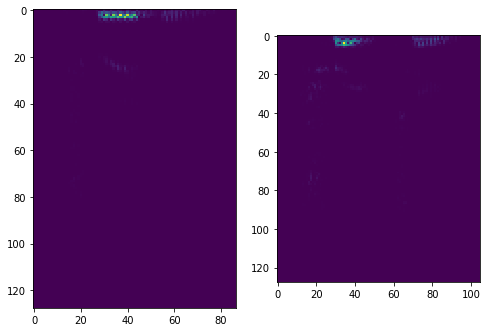

In [93]:
us_sg =polly.sg_transform(
                us_audio
            )

uk_sg = polly.sg_transform(
                uk_audio
            )
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(us_sg[0][:128, :])
fig.add_subplot(1, 2, 2)
plt.imshow(uk_sg[0][:128, :])
plt.imsave('polly_accent_transfer.png')

In [94]:
class ATModel(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, batch_size):
        super(ATModel, self).__init__()
#         self.embedding_size = 1024
#         self.seq_len = 8 
#         self.features = int(self.embedding_size/self.seq_len)
        self.features = 128
        self.embedding_size = 256
        self.hidden_size = 256
#         self.conv1 = nn.Conv2d(
#             in_channels, out_channels, kernel_size=3, stride=stride, padding=1
#         )
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(
#             out_channels, out_channels, kernel_size=3, stride=stride, padding=1
#         )
#         self.bn2 = nn.BatchNorm2d(out_channels)
        
#         self.maxpool = nn.MaxPool2d(kernel_size=2)
        
#         self.conv_fc = nn.Linear(768, self.embedding_size)
        
        self.encoder = nn.Linear(self.features, self.embedding_size)
        
        self.lstm = nn.LSTM(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=3,
            batch_first=False,
            bidirectional=False
        )
        
        self.decoder = nn.Linear(self.hidden_size, self.features)
#         self.deconv1 = nn.ConvTranspose2d(1, 3, 4, stride=2, padding=1)
#         self.bn_dc1 = nn.BatchNorm2d(3)
        
#         self.deconv2 = nn.ConvTranspose2d(3, 1, 4, stride=2, padding=1)
#         self.bn_dc2 = nn.BatchNorm2d(1)
        
    def forward(self, x):
        print('input:', x.shape)
        x = self.encoder(x)
        print('encoder -> out:', x.shape)
        x, (h_n, c_n) = self.lstm(x)
        print('lstm -> out:', x.shape)
        seq_len, batch_size, hidden_size = x.shape
        x = x.view(seq_len * batch_size, hidden_size)
        print('view -> out:', x.shape)
        x = self.decoder(x)
        print('decoder -> out:', x.shape)
        sl_bs, decoded_size = x.shape
        return x.view(seq_len, batch_size, decoded_size)

In [ ]:
torch.cuda.empty_cache()

In [97]:
model = ATModel(in_channels=1, out_channels=3, kernel_size=3, stride=2, padding=1, batch_size=batch_size)
# count_parameters(model)
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)
model.train()
criterion = nn.CTCLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, threshold=1e-5)

cuda:1


In [98]:
print(device)
model.to(device)
model.train()
criterion = nn.CTCLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, threshold=1e-5)

# overfit to minibatch
iter_train = iter(loader_train)

sg_size = 128
decoded_size = 128

steps = 10000
sample = iter_train.next() # retrieve minibatch
(inputs, targets), (input_lens, target_lens) = sample
inputs, targets = inputs.to(device), targets.to(device)

epoch_pbar = tqdm_notebook(range(steps))

for steps in epoch_pbar:
    import ipdb
    ipdb.set_trace()
    output = model.forward(inputs)
    # output_size -> seq_len, batch_size, decoded_size
    # converting to this repr for CTC loss
    input_seq_len, batch_size, decoded_size = output.shape
#     output = output.view(batch_size, -1)
    batch_size, target_seq_len, _ = targets.shape
    targets = targets.view(batch_size, -1)
    loss = criterion(output, targets, input_lens * input_seq_len, target_lens * target_seq_len)
    epoch_pbar.set_description("Loss: {}".format(str(loss.item())))
    loss.backward()
    optimizer.step()
    scheduler.step(loss.item())
    optimizer.zero_grad()

cuda:1


> <ipython-input-98-c0031216bb28>(25)<module>()
     24     ipdb.set_trace()
---> 25     output = model.forward(inputs)
     26     # output_size -> seq_len, batch_size, decoded_size

ipdb> n
input: torch.Size([365, 65, 128])
encoder -> out: torch.Size([365, 65, 256])
lstm -> out: torch.Size([365, 65, 256])
view -> out: torch.Size([23725, 256])
decoder -> out: torch.Size([23725, 128])
> <ipython-input-98-c0031216bb28>(28)<module>()
     27     # converting to this repr for CTC loss
---> 28     input_seq_len, batch_size, decoded_size = output.shape
     29     output = output.view(batch_size, -1)

ipdb> n
> <ipython-input-98-c0031216bb28>(29)<module>()
     28     input_seq_len, batch_size, decoded_size = output.shape
---> 29     output = output.view(batch_size, -1)
     30     batch_size, target_seq_len, _ = targets.shape

ipdb> n
> <ipython-input-98-c0031216bb28>(30)<module>()
     29     output = output.view(batch_size, -1)
---> 30     batch_size, target_seq_len, _ = targets.shape
  

BdbQuit: 

In [ ]:
sample = iter_train.next()

In [ ]:
audio_t = transforms.GriffinLim(n_fft=255)

In [ ]:
preds = model.forward(img.to(device))

In [ ]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(preds[0].cpu().squeeze(0).detach().numpy())
fig.add_subplot(1, 2, 2)
plt.imshow(labels[0].cpu().squeeze(0).detach().numpy())

In [ ]:
IPython.display.Audio(audio_t(preds[8].cpu()).detach().numpy(), rate=22050)

In [ ]:
epochs = 90
model.train()

writer = SummaryWriter()

epoch_pbar = tqdm_notebook(range(epochs))

for epoch in epoch_pbar:
    # training
    iter_train = iter(loader_train)
    offset = epoch * len(loader_train) # training_iter offset
    data_pbar = tqdm_notebook(range(len(loader_train)))
    train_loss = 0
    bad_batches = 0
    for data in data_pbar:
        # hack to bypass dataloading error.
        # will result in lower loss than actual (since dividing by larger number)
        try:
            img, labels = iter_train.next()
        except:
            bad_batches += 1
        img, labels = img.to(device), labels.to(device)
        output = model.forward(img)
        
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        data_pbar.set_description("Training Loss: {}".format(str(loss.item())))
        global_batch_num = offset + data
        writer.add_scalar('Loss/train', loss.item(), global_batch_num) # plotting train loss over batch_num
        train_loss += loss.item()
    print('bad_batches:', bad_batches)
    train_loss /= len(loader_train)
    print('avg train loss:', train_loss)
    scheduler.step(train_loss)
    torch.cuda.empty_cache()